## Предварительный анализ 
### Загрузим необходимые библиотеки 

In [1]:
from io import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from sklearn.datasets import load_iris, load_wine, load_boston
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.svm import NuSVR
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df = pd.read_csv('gpu_specs_v6.csv')

In [3]:
df.head()

,manufacturer,productName,releaseYear,memSize,memBusWidth,gpuClock,memClock,unifiedShader,tmu,rop,pixelShader,vertexShader,igp,bus,memType,gpuChip
0,NVIDIA,GeForce RTX 4050,2023.0,8.0,128.0,1925,2250.0,3840.0,120,48,NaN,NaN,No,PCIe 4.0 x16,GDDR6,AD106
1,Intel,Arc A350M,2022.0,4.0,64.0,300,1500.0,768.0,48,24,NaN,NaN,No,PCIe 4.0 x8,GDDR6,DG2-128
2,Intel,Arc A370M,2022.0,4.0,64.0,300,1500.0,1024.0,64,32,NaN,NaN,No,PCIe 4.0 x8,GDDR6,DG2-128
3,Intel,Arc A380,2022.0,4.0,64.0,300,1500.0,1024.0,64,32,NaN,NaN,No,PCIe 4.0 x8,GDDR6,DG2-128
4,Intel,Arc A550M,2022.0,8.0,128.0,300,1500.0,2048.0,128,64,NaN,NaN,No,PCIe 4.0 x16,GDDR6,DG2-512


### Изучим полученные данные

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2889 entries, 0 to 2888
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   manufacturer   2889 non-null   object 
 1   productName    2889 non-null   object 
 2   releaseYear    2845 non-null   float64
 3   memSize        2477 non-null   float64
 4   memBusWidth    2477 non-null   float64
 5   gpuClock       2889 non-null   int64  
 6   memClock       2477 non-null   float64
 7   unifiedShader  2065 non-null   float64
 8   tmu            2889 non-null   int64  
 9   rop            2889 non-null   int64  
 10  pixelShader    824 non-null    float64
 11  vertexShader   824 non-null    float64
 12  igp            2889 non-null   object 
 13  bus            2889 non-null   object 
 14  memType        2889 non-null   object 
 15  gpuChip        2889 non-null   object 
dtypes: float64(7), int64(3), object(6)
memory usage: 361.2+ KB


In [5]:
columns_to_replace = ['memSize', 'memBusWidth', 'memClock', 'unifiedShader', 'pixelShader', 'vertexShader']
for column in columns_to_replace:
    df[column] = df[column].fillna(0)
df.dropna(subset=['releaseYear'],inplace = True, axis = 0)
df.isna().sum()

manufacturer     0
productName      0
releaseYear      0
memSize          0
memBusWidth      0
gpuClock         0
memClock         0
unifiedShader    0
tmu              0
rop              0
pixelShader      0
vertexShader     0
igp              0
bus              0
memType          0
gpuChip          0
dtype: int64

In [6]:
# удаляем ненужные строки
df.drop(['manufacturer','productName','bus','memType','gpuChip'], axis=1, inplace=True)

In [7]:
df["igp"] = df['igp'].replace({'No': 0, 'Yes': 1}).astype(int)
df.head()

,releaseYear,memSize,memBusWidth,gpuClock,memClock,unifiedShader,tmu,rop,pixelShader,vertexShader,igp
0,2023.0,8.0,128.0,1925,2250.0,3840.0,120,48,0.0,0.0,0
1,2022.0,4.0,64.0,300,1500.0,768.0,48,24,0.0,0.0,0
2,2022.0,4.0,64.0,300,1500.0,1024.0,64,32,0.0,0.0,0
3,2022.0,4.0,64.0,300,1500.0,1024.0,64,32,0.0,0.0,0
4,2022.0,8.0,128.0,300,1500.0,2048.0,128,64,0.0,0.0,0


In [8]:
print('Интегрированная графика:')
print(df[df['igp']==1].describe().T)
print('\nДискретная графика:')
print(df[df['igp']==0].describe().T)

Интегрированная графика:
               count         mean         std     min     25%     50%     75%   
releaseYear    412.0  2012.165049    5.448002  1998.0  2008.0  2013.0  2016.0  \
memSize        412.0     0.000000    0.000000     0.0     0.0     0.0     0.0   
memBusWidth    412.0     0.000000    0.000000     0.0     0.0     0.0     0.0   
gpuClock       412.0   425.910194  208.681854    66.0   300.0   370.0   500.0   
memClock       412.0     0.000000    0.000000     0.0     0.0     0.0     0.0   
unifiedShader  412.0   182.757282  188.414228     0.0    16.0   128.0   320.0   
tmu            412.0    15.519417   13.498026     1.0     4.0    12.0    24.0   
rop            412.0     4.856796    3.909111     1.0     2.0     4.0     8.0   
pixelShader    412.0     0.864078    3.595884     0.0     0.0     0.0     0.0   
vertexShader   412.0     0.310680    1.429812     0.0     0.0     0.0     0.0   
igp            412.0     1.000000    0.000000     1.0     1.0     1.0     1.0   

  

## С использованием метода train_test_split разделим выборку на обучающую и тестовую.
### Построим модель бинарной классификации видеокарт, где целевой признак - является ли видеокарта интегрированной.

In [9]:
X = df.drop(['igp'], axis = 1)
y = df['igp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

### Логистическая регрессия

In [10]:
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
print('Метрики для модели логистической регрессии:')
print('accuracy_score: {}\nprecision_score: {}\nrecall_score:{}'.format(
    accuracy_score(y_test, lr_predictions),
    precision_score(y_test, lr_predictions),
    recall_score(y_test, lr_predictions)
))

Метрики для модели логистической регрессии:
accuracy_score: 0.9982425307557118
precision_score: 1.0
recall_score:0.9891304347826086


In [11]:
features = pd.DataFrame(lr_model.coef_.T, X.columns).reset_index()
features.columns = ['feature', 'coef']
features['coef'] = features['coef'].apply(lambda x: abs(x))
features = features.sort_values(by='coef', ascending=False)
print('\nКоэффициенты признаков в оптимальной функции логистической регрессии:')
print(features)


Коэффициенты признаков в оптимальной функции логистической регрессии:
         feature      coef
4       memClock  8.272012
2    memBusWidth  2.968013
0    releaseYear  2.194263
7            rop  0.725915
3       gpuClock  0.515978
1        memSize  0.496792
9   vertexShader  0.451015
6            tmu  0.231938
8    pixelShader  0.200075
5  unifiedShader  0.082808


## SVM

In [12]:
# SVM
scaler = StandardScaler().fit(X_train)
x_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)
x_train_scaled.describe()

,releaseYear,memSize,memBusWidth,gpuClock,memClock,unifiedShader,tmu,rop,pixelShader,vertexShader
count,2.276000e+03,2.276000e+03,2.276000e+03,2.276000e+03,2.276000e+03,2.276000e+03,2.276000e+03,2.276000e+03,2.276000e+03,2.276000e+03
mean,1.499211e-14,-4.370650e-17,-1.795088e-17,-3.121893e-17,5.385265e-17,-1.560946e-18,9.755914e-18,7.492542e-17,6.243785e-18,-1.560946e-17
std,1.000220e+00,1.000220e+00,1.000220e+00,1.000220e+00,1.000220e+00,1.000220e+00,1.000220e+00,1.000220e+00,1.000220e+00,1.000220e+00
min,-4.008804e+00,-3.894468e-01,-3.837923e-01,-1.761104e+00,-1.334554e+00,-5.000606e-01,-6.467931e-01,-7.524922e-01,-3.607251e-01,-4.139932e-01
25%,-7.606594e-01,-3.712850e-01,-2.782065e-01,-7.065687e-01,-8.914008e-01,-5.000606e-01,-5.396689e-01,-5.933330e-01,-3.607251e-01,-4.139932e-01
50%,5.137662e-02,-3.167995e-01,-1.726207e-01,-1.657813e-01,8.353549e-02,-3.724446e-01,-3.789825e-01,-4.341738e-01,-3.607251e-01,-4.139932e-01
75%,7.010055e-01,-1.056682e-01,3.855088e-02,5.750974e-01,6.755877e-01,1.040338e-02,1.030765e-01,2.024629e-01,6.453043e-03,-4.139932e-01
max,2.000263e+00,1.777238e+01,1.313119e+01,4.514734e+00,2.666230e+00,1.073015e+01,1.113687e+01,9.433696e+00,8.451550e+00,1.256017e+01


In [13]:
nusvr_05 = NuSVR(nu=0.7, gamma = 'scale')
nusvr_05.fit(X_train, y_train)

NuSVR(nu=0.7)

## Дерево решений

In [14]:
dt_none = DecisionTreeRegressor(max_depth=3)
dt_none.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

[Text(0.5, 0.75, 'X[1] <= 0.0\nsquared_error = 0.121\nsamples = 2276\nvalue = 0.141'),
 Text(0.25, 0.25, 'squared_error = 0.0\nsamples = 320\nvalue = 1.0'),
 Text(0.75, 0.25, 'squared_error = 0.0\nsamples = 1956\nvalue = 0.0')]

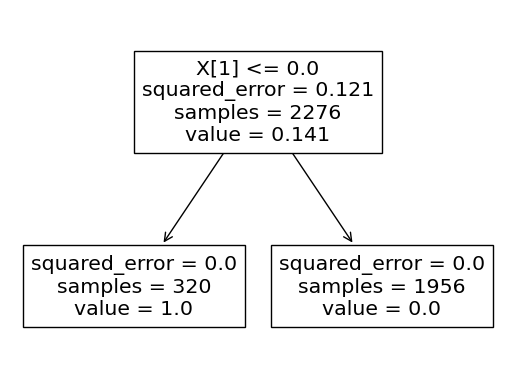

In [15]:
tree.plot_tree(dt_none)

In [16]:
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [17]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

In [18]:
test_model(dt_none)

mean_absolute_error: 0.0017574692442882249
median_absolute_error: 0.0
r2_score: 0.9870339987239085


In [19]:
from IPython.core.display import HTML
from sklearn.tree import export_text
tree_rules = export_text(dt_none, feature_names=list(X.columns))
HTML('<pre>' + tree_rules + '</pre>')

In [20]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

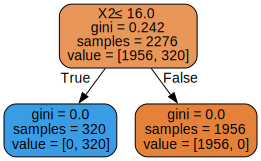

In [21]:
dot_data = export_graphviz(clf, out_file=None,  
                           filled=True, rounded=True, special_characters=True,max_depth=3)  
graph = graphviz.Source(dot_data)  
graph

## Важность признаков

In [22]:
list(zip(X_train.columns.values, clf.feature_importances_))

[('releaseYear', 0.0),
 ('memSize', 0.0),
 ('memBusWidth', 1.0),
 ('gpuClock', 0.0),
 ('memClock', 0.0),
 ('unifiedShader', 0.0),
 ('tmu', 0.0),
 ('rop', 0.0),
 ('pixelShader', 0.0),
 ('vertexShader', 0.0)]

In [23]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

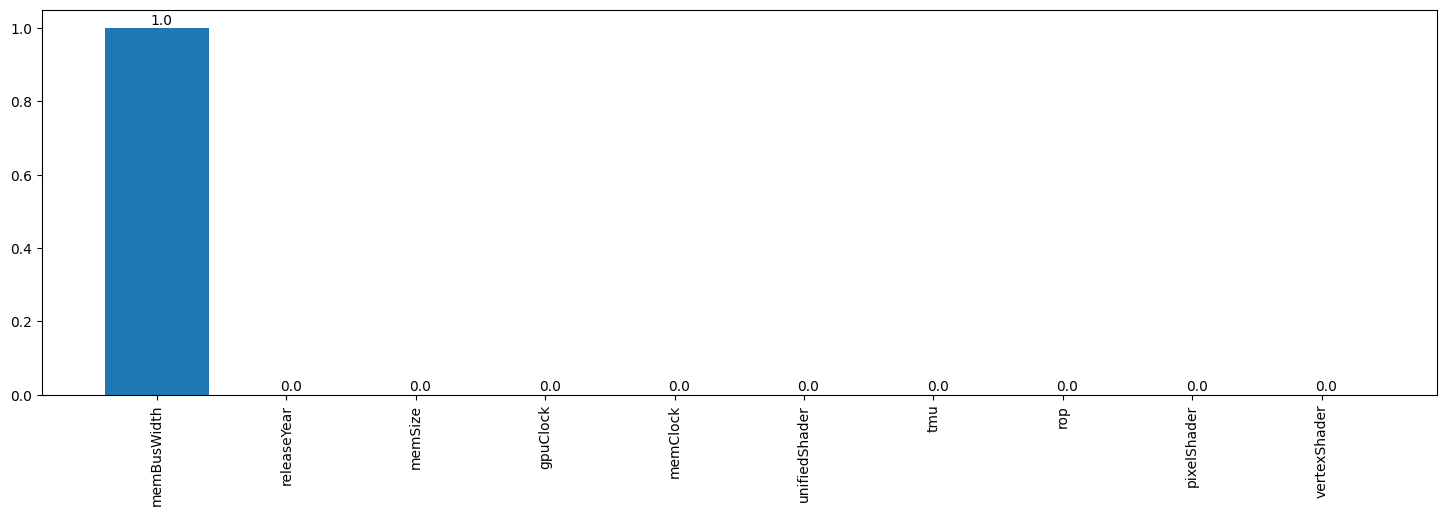

In [24]:
dt_fl, dt_fd = draw_feature_importances(clf, X_train)